# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name: Chuqiao Song

ID: A53239614

## Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import math

#environment
import gym
import os
import time
#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

logging_interval = 100
animate_interval = logging_interval * 5
logdir='./DDPG/'

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [2]:
VISUALIZE = True
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
# env_name = 'InvertedPendulum-v1'
env_name = 'Pendulum-v0'
# env_name = 'HalfCheetah-v1' 

# wrap gym to save videos
env = gym.make(env_name)
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


[2018-05-15 14:26:11,517] Making new env: Pendulum-v0
[2018-05-15 14:26:11,532] Clearing 2 monitor files from previous run (because force=True was provided)


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

Ans: 

Pendulum-v0
- reward = -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2)
- x1 = cos(theta) within [-1,1]; x2 = sin(theta) within [-1,1]; x3 = theta_dot within [-8,8] where theta is the angular of the pendulum, and theta_dot is the angular velocity of the pendulum.
- joint effore within [-2,2]
- In general, the pendulum starts randomly at angle from -pi to pi, with random velocity between -1 and 1. There is no specific termination, so I have to manual set up a maximum number of steps for one episode. Also, to optimize this model, we want the pendulum to remain at zero angle (vertical), with least angular velocity as well as the least effort.





HalfCheetah-v1
- To produce reward in each step, there are two ingredients, one is called reward_control and the other called reward_run. reward_ctrl = - 0.1 * np.square(action).sum(), where action has 6 dimensions

 reward_ctrl = - 0.1 * np.square(action).sum()
        reward_run = (xposafter - xposbefore)/self.dt
        reward = reward_ctrl + reward_run
- State space

          (name)    (joint)     (parameter)
        - rootx     slider      position (m)
        - rootz     slider      position (m)
        - rooty     hinge       angle (rad)
        - bthigh    hinge       angle (rad)
        - bshin     hinge       angle (rad)
        - bfoot     hinge       angle (rad)
        - fthigh    hinge       angle (rad)
        - fshin     hinge       angle (rad)
        - ffoot     hinge       angle (rad)
        - rootx     slider      velocity (m/s)
        - rootz     slider      velocity (m/s)
        - rooty     hinge       angular velocity (rad/s)
        - bthigh    hinge       angular velocity (rad/s)
        - bshin     hinge       angular velocity (rad/s)
        - bfoot     hinge       angular velocity (rad/s)
        - fthigh    hinge       angular velocity (rad/s)
        - fshin     hinge       angular velocity (rad/s)
        - ffoot     hinge       angular velocity (rad/s)
- Action space

          (name)   (actuator)   (parameter):
        - bthigh    hinge       torque (N m)
        - bshin     hinge       torque (N m)
        - bfoot     hinge       torque (N m)
        - fthigh    hinge       torque (N m)
        - fshin     hinge       torque (N m)
        - ffoot     hinge       torque (N m)
InvertedPendulum-v1


### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [3]:
class NormalizeAction(gym.ActionWrapper):
    def action(self, act):
        # [-1, 1] => [action_space.low, action_space.high]
        #tanh outputs (-1,1) from tanh, need to be [action_space.low, action_space.high]
        act = (act + 1)/2  #[-1, 1] => [0,1]
        act = act * (self.action_space.high - self.action_space.low)
        act = act + self.action_space.low
        return act
    
    def reverse_action(self, act):
        # [action_space.low, action_space.high] => [-1,1]
        #reverse of that above
        act = act - self.action_space.low
        act = act / (self.action_space.high - self.action_space.low)
        act = act * 2 - 1
        return act


# DDPG

### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [4]:
def weightSync(target_model, source_model, tau = 0.001):
    # soft update
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [5]:
class Replay():
    def __init__(self):
        self.capacity = 60000
        self.memory = []
        self.position = 0
        self.gamma = 0.99

    def initialize(self, init_length, envir):
        st = envir.reset()
        for _ in range(init_length):
            a = envir.action_space.sample()
            st1, r, done, info = envir.step(a)
            # normalizing action 
            # [action_space.low, action_space.high] => [-1,1]
            a = envir.reverse_action(a)
            self.push((st, a, st1, r, done))
            if done: st = envir.reset()
            else : st = st1
                
    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity
        
    def generateMinibatch(self, batch_size):
        batch_memory = random.sample(self.memory, batch_size) #return a list
        batch_memory = list(zip(*batch_memory))
        
        batch_st = Variable(FloatTensor(batch_memory[0]))
        batch_at = Variable(FloatTensor(batch_memory[1]))
        batch_st1 = Variable(FloatTensor(batch_memory[2]))
        batch_r = Variable(torch.unsqueeze(FloatTensor(batch_memory[3]),1))
        batch_done = torch.unsqueeze(FloatTensor(batch_memory[4]),1)
        
        return batch_st, batch_at, batch_st1, batch_r, batch_done
        
    def __len__(self):            
        return len(self.memory)


### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.25, mu = 0, sigma = 0.05, dt = 0.01

In [6]:
class OrnsteinUhlenbeckProcess():
    def __init__(self, mu=np.zeros(act_dim), sigma=0.3, theta=.15, dimension=1e-2, x0=None,num_steps=12000):
    # for inverted pendulum and pendulum above
#     def __init__(self, mu=np.zeros(act_dim), sigma=0.05, theta=.15, dimension=1e-2, x0=None,num_steps=12000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dimension
        self.x0 = x0
        self.reset()
        
    def step(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x
    
    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)
    

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [7]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
        self.bn1 = nn.BatchNorm1d(400) # batchnormalization
        self.fc2 = nn.Linear(400, 400)
        self.bn2 = nn.BatchNorm1d(400) # batchnormalization
        self.fc3 = nn.Linear(400, output_size)
        
        # parameters initialization
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.normal_(self.fc1.bias)
        nn.init.normal_(self.fc2.bias)
        nn.init.normal_(self.fc3.bias)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)  # turn off for inverted-pendulum -v1
        x = F.relu(self.fc2(x))
        x = self.bn2(x)  # turn off for inverted-pendulum -v1
        
        outputs = F.tanh(self.fc3(x))
        return outputs


# ----------------------------------------------------
# critic model, MLP
# ----------------------------------------------------
# 2 hidden layers, 300 units per layer, ouputs rewards therefore unbounded
# Action not to be included until 2nd layer of critic (from paper). Make sure to formulate your critic.forward() accordingly

class critic(nn.Module):
    def __init__(self, state_size, action_size, output_size):
        super(critic, self).__init__()

        self.fc1 = nn.Linear(state_size, 300)
        self.bn1 = nn.BatchNorm1d(300) # batchnormalization
        self.fc2 = nn.Linear(300 + action_size, 300)
        self.fc3 = nn.Linear(300, output_size)

        # parameters initialization
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.normal_(self.fc1.bias)
        nn.init.normal_(self.fc2.bias)
        nn.init.normal_(self.fc3.bias)
    
    def forward(self, states, actions):
        x = F.relu(self.fc1(states))
        x = self.bn1(x)  # turn off for inverted-pendulum -v1
        x = torch.cat((x, actions), 1) # actions only join at second layer
        x = F.relu(self.fc2(x))
        
        outputs = self.fc3(x)
        return outputs



### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [8]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)

        # replay buffer 
        self.replayBuffer = Replay()
        
        
    def train(self):
        # sample from Replay
        b_st, b_at, b_st1, b_r, b_d = self.replayBuffer.generateMinibatch(self.batch_size)

        ## update critic (create target for Q function)       
        # below is for target actor network
        targetActorPredict_b_at1 = self.actor_target(b_st1)
        
        #below is for target critic network
        mask = 1 - b_d   # if done is true, change the target to just reward
        batch_Q_next = self.critic_target(b_st1, targetActorPredict_b_at1)
        QQ_next = Variable((batch_Q_next.data * mask).view(self.batch_size, 1))
        b_Q_critic_target = b_r + self.gamma*(QQ_next)
        
        
        # below is for behavior critic network
        b_Q_critic_behaviorQ = self.critic(b_st, b_at)
        
        ## critic optimizer and backprop step (feed in target and predicted values to self.critic_loss)
        critic_loss = self.critic_loss(b_Q_critic_behaviorQ, b_Q_critic_target.detach())
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
        
        ## update actor (formulate the loss wrt which actor is updated)
        # below is for behavior actor network
        b_at_actor_behavior = self.actor(b_st)
        # below is for behavior critic network
        b_Q_critic_behaviorP = self.critic(b_st, b_at_actor_behavior)

        ## actor optimizer and backprop step (loss_actor.backward())
        loss_actor = -1. * b_Q_critic_behaviorP
        loss_actor = loss_actor.mean()
        
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()

        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [9]:
ddpg = DDPG(obs_dim = obs_dim, act_dim = act_dim)
print(ddpg.actor)
print(ddpg.critic)

actor(
  (fc1): Linear(in_features=3, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
critic(
  (fc1): Linear(in_features=3, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=301, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [10]:
env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
term_condition = -150 # Pendulum
# term_condition = 500 # inverted pendulum
# term_condition = 1500 # halfcheetah 
ddpg.replayBuffer.initialize(1000, env)

for itr in range(NUM_EPISODES):
    state = env.reset() # get initial state
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
    total_reward = 0
    while True: # for each episode, we loop each step in this episode
        ddpg.noise.reset()
        if animate_this_episode:
            env.render()
            time.sleep(0.05)
        # use actor to get action, add ddpg.noise.step() to action
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        var_state = Variable(torch.unsqueeze(FloatTensor(state),0), requires_grad=False)
        ddpg.actor.eval()
        cuda_tensor_action = ddpg.actor(var_state)
        ddpg.actor.train()
        
        action = cuda_tensor_action.data[0].cpu().numpy()
        action = action + ddpg.noise.step()
        # below already include [-1,1] => [action_space.low, action_space.high]
        new_state, reward, done, _ = env.step(action) 
        total_reward += reward
        
        ddpg.replayBuffer.push((state, action, new_state, reward, done))
        # step action, get next state, reward, done (keep track of total_reward)
        # populate ddpg.replayBuffer
        ddpg.train() ###################### update network (per step) in one episode
        step_counter += 1
        state = new_state
        if done: break

    if avg_val > term_condition and itr >100 : break

    running_rewards_ddpg.append(total_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))
    
print('Done')

Average value: -73.4373807501195 for episode: 0
Average value: -140.85385065861686 for episode: 1
Average value: -212.52306019548462 for episode: 2
Average value: -280.1434715238472 for episode: 3
Average value: -346.2113794091961 for episode: 4
Average value: -406.1544977527362 for episode: 5
Average value: -462.87296165088196 for episode: 6
Average value: -516.6763258643674 for episode: 7
Average value: -567.0071775943572 for episode: 8
Average value: -622.5982884418002 for episode: 9
Average value: -670.1291225402183 for episode: 10
Average value: -709.4823288010274 for episode: 11
Average value: -754.1306287039704 for episode: 12
Average value: -793.219518670281 for episode: 13
Average value: -816.5035345778631 for episode: 14
Average value: -855.3519711906908 for episode: 15
Average value: -890.1783577032271 for episode: 16
Average value: -901.9146334886112 for episode: 17
Average value: -934.7295435349396 for episode: 18
Average value: -966.3363765221197 for episode: 19
Average v

Average value: -190.03280026459828 for episode: 162
Average value: -192.4852853349344 for episode: 163
Average value: -189.24278955375013 for episode: 164
Average value: -198.68286196424637 for episode: 165
Average value: -207.74129555084565 for episode: 166
Average value: -203.6019853200193 for episode: 167
Average value: -199.92400010660464 for episode: 168
Average value: -196.2729532042105 for episode: 169
Average value: -203.31641868219592 for episode: 170
Average value: -199.38656635181744 for episode: 171
Average value: -195.26786731373724 for episode: 172
Average value: -197.39256798436315 for episode: 173
Average value: -199.47195112925272 for episode: 174
Average value: -189.53528359636945 for episode: 175
Average value: -186.42217988921664 for episode: 176
Average value: -183.43812024261845 for episode: 177
Average value: -180.38845009952578 for episode: 178
Average value: -177.1552731081345 for episode: 179
Average value: -174.03639744601125 for episode: 180
Average value: -

## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

In [13]:
def numpy_ewma_vectorized_v2(data, window):
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

# DDPG Inverted-Pendulum

In [13]:
np.save('ddpg_inverted_pendulum_reward.npy', running_rewards_ddpg)
np.save('ddpg_inverted_pendulum_step.npy', step_list_ddpg)

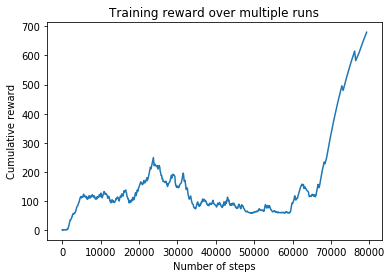

In [14]:
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)
plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()



In [19]:
# env = NormalizeAction(env) # remap action values for the environment
state = env.reset() # get initial state
while True: # for each episode, we loop each step in this episode
    ddpg.noise.reset()
    env.render()
    time.sleep(0.05)
    # use actor to get action, add ddpg.noise.step() to action
    # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
    # to train mode after you're done getting the action
    var_state = Variable(torch.unsqueeze(FloatTensor(state),0), requires_grad=False)
    
    ddpg.actor.eval()
    cuda_tensor_action = ddpg.actor(var_state)
    action = cuda_tensor_action.data[0].cpu().numpy()
    action = action + ddpg.noise.step()
    # below already include [-1,1] => [action_space.low, action_space.high]
    new_state, reward, done, _ = env.step(action) 
    # step action, get next state, reward, done (keep track of total_reward)
    # populate ddpg.replayBuffer
    state = new_state
    if done: break

print('done')

done


# DDPG Pendulum

In [14]:
np.save('ddpg_pendulum_reward.npy', running_rewards_ddpg)
np.save('ddpg_pendulum_step.npy', step_list_ddpg)

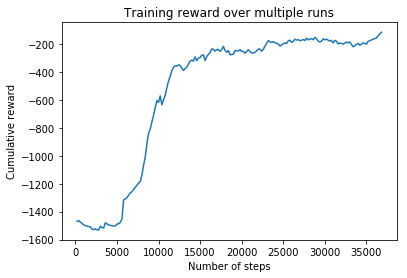

In [15]:
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)
plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

In [19]:
# env = NormalizeAction(env) # remap action values for the environment
state = env.reset() # get initial state
while True: # for each episode, we loop each step in this episode
    ddpg.noise.reset()
    env.render()
    time.sleep(0.05)
    # use actor to get action, add ddpg.noise.step() to action
    # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
    # to train mode after you're done getting the action
    var_state = Variable(torch.unsqueeze(FloatTensor(state),0), requires_grad=False)
    
    ddpg.actor.eval()
    cuda_tensor_action = ddpg.actor(var_state)
    action = cuda_tensor_action.data[0].cpu().numpy()
    action = action + ddpg.noise.step()
    # below already include [-1,1] => [action_space.low, action_space.high]
    new_state, reward, done, _ = env.step(action) 
    # step action, get next state, reward, done (keep track of total_reward)
    # populate ddpg.replayBuffer
    state = new_state
    if done: break

print('done')

done


# DDPG HalfCheetah

In [ ]:
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)
plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()


# env = NormalizeAction(env) # remap action values for the environment
state = env.reset() # get initial state
while True: # for each episode, we loop each step in this episode
    ddpg.noise.reset()
    env.render()
    time.sleep(0.05)
    # use actor to get action, add ddpg.noise.step() to action
    # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
    # to train mode after you're done getting the action
    var_state = Variable(torch.unsqueeze(FloatTensor(state),0), requires_grad=False)
    
    ddpg.actor.eval()
    cuda_tensor_action = ddpg.actor(var_state)
    action = cuda_tensor_action.data[0].cpu().numpy()
    action = action + ddpg.noise.step()
    # below already include [-1,1] => [action_space.low, action_space.high]
    new_state, reward, done, _ = env.step(action) 
    # step action, get next state, reward, done (keep track of total_reward)
    # populate ddpg.replayBuffer
    state = new_state
    if done: break

print('done')

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [3]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    # For discrete, it is the number of actions for outputs
    # For continuous, it is the dimension of action
    def __init__(self, Dim_state, num_outputs, disct):
        super(mlp, self).__init__()
        self.disct = disct
        if self.disct == True:
            self.fc1 = nn.Linear(Dim_state, 50)
            self.fc2 = nn.Linear(50, 50)
            self.fc3 = nn.Linear(50, num_outputs)
            # parameters initialization
#             nn.init.xavier_normal_(self.fc1.weight)
#             nn.init.xavier_normal_(self.fc2.weight)
#             nn.init.xavier_normal_(self.fc3.weight)
#             nn.init.normal_(self.fc1.bias)
#             nn.init.normal_(self.fc2.bias)
#             nn.init.normal_(self.fc3.bias)
            
        else:
            self.fc1 = nn.Linear(Dim_state, 50)
            self.fc2 = nn.Linear(50, 50)
            self.fc_mu = nn.Linear(50, num_outputs)
            self.fc_sigma = nn.Linear(50, num_outputs)

            
            # parameters initialization
#             nn.init.xavier_normal_(self.fc1.weight)
#             nn.init.xavier_normal_(self.fc2.weight)
            
#             nn.init.xavier_normal_(self.fc_mu.weight)
#             nn.init.xavier_normal_(self.fc_sigma.weight)
            
#             nn.init.normal_(self.fc1.bias)
#             nn.init.normal_(self.fc2.bias)
            
#             nn.init.normal_(self.fc_mu.bias)
#             nn.init.normal_(self.fc_sigma.bias)
            
        
    def forward(self, x):
        if self.disct == True:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            actions_prob = F.softmax(x, dim=1)
            return actions_prob
        else: 
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            mu = self.fc_mu(x)
            sigma = self.fc_sigma(x)
            return [mu, sigma]

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [4]:
def sample_action(logit, disct):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
    if disct == True:
        action_distribution=torch.distributions.Categorical(logit)
        action = action_distribution.sample()
        log_odds = action_distribution.log_prob(action)
        
    else : # continuous 
        mean = logit[0]
        cov = F.softplus(logit[1])
        action_distribution = torch.distributions.normal.Normal(mean, cov)
        action = action_distribution.sample()
        log_odds = action_distribution.log_prob(action)
    return action, log_odds


Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [5]:
def reward2go(rewards, gamma =1):
    r2g = []
    acc_r = 0
    for r in reversed(rewards):
        acc_r = acc_r * gamma + r
        r2g.append(acc_r)
    return r2g[::-1]


def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object
    
    num_paths = len(paths)
    rew_cums = []
    log_odds = []
    # calculated as "reward to go"
    
    for path in paths:
        # rew_cums should record return at each time step for each path
        rew_cums += reward2go(path['reward'])
        # log_odds should record log_odds obtained at each timestep of path
        log_odds += path['log_odds']
        # calculated as "reward to go" 

    # make log_odds, rew_cums each a vector
    rew_cums = np.array(rew_cums)
    log_odds = np.array(log_odds)
    rew_cums = (rew_cums - rew_cums.mean()) / (rew_cums.std() + 1e-5) # create baseline
    # calculate policy loss and average over paths
    policy_loss = -rew_cums.dot(log_odds)/ num_paths
    
    # take optimizer step
    optimizer.zero_grad()
    policy_loss.sum().backward()  # sum for cheetah, or may delete this sum for other env
    optimizer.step() 

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [6]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# Select Environment

######discrete environment:
# env_name='CartPole-v0'

######continous environments:
# env_name='InvertedPendulum-v1'
env_name = 'HalfCheetah-v1'


# Make the gym environment
env = gym.make(env_name)
visualize = False
# animate=visualize
learning_rate = 1e-3

max_path_length=None
min_timesteps_per_batch = 2000  # sets the batch size for updating network

# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)


# Saving parameters
logdir='./REINFORCE/'

if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

env._max_episodes_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)


# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Make network object (remember to pass in appropriate flags for the type of action space in use)
# net = mlp(*args)
net = mlp(Dim_state = obs_dim, num_outputs = act_dim, disct = discrete).type(FloatTensor)

# Make optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
print(net)

[2018-05-15 14:26:39,297] Making new env: HalfCheetah-v1
[2018-05-15 14:26:39,630] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/85/185/chs140/ECE276C/PA3/DDPG')


mlp(
  (fc1): Linear(in_features=17, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc_mu): Linear(in_features=50, out_features=6, bias=True)
  (fc_sigma): Linear(in_features=50, out_features=6, bias=True)
)


## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

In [7]:
n_iter = 1000 
min_timesteps_per_batch = 2000  # sets the batch size for updating network
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0

for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()   
        animate_this_episode = (itr % animate_interval == 0) and visualize
        obs, acs, rews, log_odds = [], [], [], [] 
        obs.append(ob)

        while True: # loop for episode inside batch
            if animate_this_episode:
                env.render()
                time.sleep(0.05)
            # get parametrized policy distribution from net using current state ob
            net.eval()
            var_ob = Variable(torch.unsqueeze(FloatTensor(ob),0), requires_grad=False)
            distribution_parameters = net(var_ob)
            
            net.train()
            # sample action and get log-probability (log_odds) from distribution
            cuda_tensor_ac, log_odd= sample_action(logit = distribution_parameters , disct = discrete)
            ac = cuda_tensor_ac.data[0].cpu().numpy()
            
            # step environment, record reward, next state
            ob, rew, done, _ = env.step(ac)
            # append to obs, acs, rewards, log_odds
            obs.append(ob)
            acs.append(ac)
            rews.append(rew)
            log_odds.append(log_odd)
            
            # if done, restart episode till min_timesteps_per_batch is reached     
            steps += 1
            
            if done:
                episodes = episodes + 1
                break
                
        path = {"observation" : obs, 
                "reward" : np.array(rews), 
                "action" : (acs),
                "log_odds" : log_odds}
        
        paths.append(path)
        if steps > min_timesteps_per_batch: break 

    update_policy(paths, net)  # use all complete episodes (a batch of timesteps) recorded in this itr to update net
    if itr == 0: avg_reward = path['reward'].sum()
        
    else: avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
        
    if avg_reward > 1500: break
    # inverted 500, half_cheetah 1500, cartpole 200
    total_steps += steps
    print(avg_reward,end='\r')
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % logging_interval == 0: print('Average reward: {}'.format(avg_reward))   
        
env.close()
print('done')


Average reward: -631.3082183173344
Average reward: -619.8083439120957
Average reward: -479.22020007268867
Average reward: -535.6534700193245
Average reward: -483.31511565534953
Average reward: -700.0253135620237
Average reward: -539.8485582303404
Average reward: -486.3342675842881
Average reward: -573.6608333884494
Average reward: -762.6001722762232
done.59865768538844


# Reinforce CartPole-v0

In [22]:
np.save('reinforce_cartpole_reward.npy', avg_rewards)
np.save('reinforce_cartpole_step.npy', step_list_reinforce)

Text(0,0.5,'Average reward')

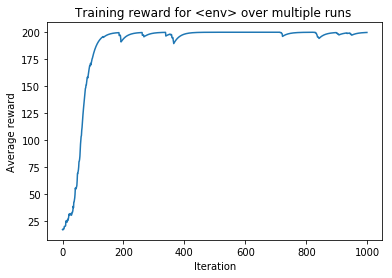

In [23]:
plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

In [19]:
env_name='CartPole-v0'

# Make the gym environment
env = gym.make(env_name)
visualize = True
animate=visualize
learning_rate = 1e-3

max_path_length=None
min_timesteps_per_batch = 2000  # sets the batch size for updating network

# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# Saving parameters
logdir='./REINFORCE/'

if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

env._max_episodes_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

[2018-05-15 10:00:46,789] Making new env: CartPole-v0
[2018-05-15 10:00:46,795] Clearing 2 monitor files from previous run (because force=True was provided)


In [21]:
########### for saving optimal model video

ob = env.reset() 
while True:
    env.render()
    time.sleep(0.05)
    # get parametrized policy distribution from net using current state ob
    net.eval()
    var_ob = Variable(torch.unsqueeze(FloatTensor(ob),0), requires_grad=False)
    distribution_parameters = net(var_ob)
    # sample action and get log-probability (log_odds) from distribution
    cuda_tensor_ac, log_odd= sample_action(logit = distribution_parameters , disct = discrete)
    ac = cuda_tensor_ac.data[0].cpu().numpy()
    # step environment, record reward, next state
    new_ob, rew, done, _ = env.step(ac)
    ob = new_ob
    if done: break
print('done')

done


# Reinforce Inverted Pendulum-v1

In [39]:
np.save('reinforce_inverted_pendulum_reward.npy', avg_rewards)
np.save('reinforce_inverted_pendulum_step.npy', step_list_reinforce)

Text(0,0.5,'Average reward')

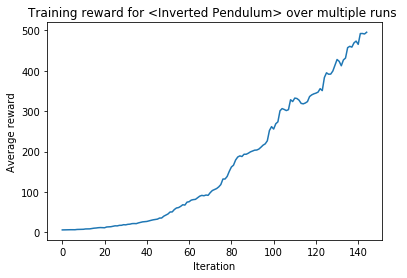

In [40]:
plt.plot(avg_rewards)
plt.title('Training reward for <Inverted Pendulum> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

In [41]:
env_name='InvertedPendulum-v1'

# Make the gym environment
env = gym.make(env_name)
visualize = True
animate=visualize
learning_rate = 1e-3

max_path_length=None
min_timesteps_per_batch = 2000  # sets the batch size for updating network

# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# Saving parameters
logdir='./REINFORCE/'

if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

env._max_episodes_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

[2018-05-15 10:17:45,697] Making new env: InvertedPendulum-v1
[2018-05-15 10:17:45,705] Clearing 6 monitor files from previous run (because force=True was provided)


In [43]:
########### for saving optimal model video

ob = env.reset() 
while True:
    env.render()
    time.sleep(0.05)
    # get parametrized policy distribution from net using current state ob
    net.eval()
    var_ob = Variable(torch.unsqueeze(FloatTensor(ob),0), requires_grad=False)
    distribution_parameters = net(var_ob)
    # sample action and get log-probability (log_odds) from distribution
    cuda_tensor_ac, log_odd= sample_action(logit = distribution_parameters , disct = discrete)
    ac = cuda_tensor_ac.data[0].cpu().numpy()
    # step environment, record reward, next state
    new_ob, rew, done, _ = env.step(ac)
    ob = new_ob
    if done: break
print('done')



done


# Reinforce HalfCheetah-v1

In [8]:
np.save('reinforce_halfcheetah_reward.npy', avg_rewards)
np.save('reinforce_halfcheetah_step.npy', step_list_reinforce)

Text(0,0.5,'Average reward')

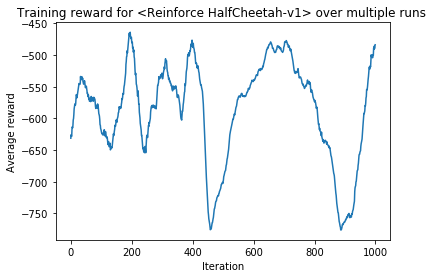

In [10]:
plt.plot(avg_rewards)
plt.title('Training reward for <Reinforce HalfCheetah-v1> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

In [11]:
env_name='HalfCheetah-v1'

# Make the gym environment
env = gym.make(env_name)
visualize = True
animate=visualize
learning_rate = 1e-3

max_path_length=None
min_timesteps_per_batch = 2000  # sets the batch size for updating network

# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# Saving parameters
logdir='./REINFORCE/'

if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

env._max_episodes_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

[2018-05-15 15:42:06,135] Making new env: HalfCheetah-v1
[2018-05-15 15:42:06,150] Clearing 4 monitor files from previous run (because force=True was provided)


In [13]:
ob = env.reset() 
while True:
    env.render()
    time.sleep(0.05)
    # get parametrized policy distribution from net using current state ob
    net.eval()
    var_ob = Variable(torch.unsqueeze(FloatTensor(ob),0), requires_grad=False)
    distribution_parameters = net(var_ob)
    # sample action and get log-probability (log_odds) from distribution
    cuda_tensor_ac, log_odd= sample_action(logit = distribution_parameters , disct = discrete)
    ac = cuda_tensor_ac.data[0].cpu().numpy()
    # step environment, record reward, next state
    new_ob, rew, done, _ = env.step(ac)
    ob = new_ob
    if done: break
print('done')

done


# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


# DQN

## 1.1 DQN environment setup

In [25]:
 # import your DQN and format your average returns as defined above
import gym
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Create the CartPole game environment
env = gym.make('CartPole-v0')
env.reset()
use_cuda = torch.cuda.is_available()
# use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

class Net(nn.Module):
# Define your network here
    def __init__(self, state_size, action_size, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(hidden_size, action_size)
        self.out.weight.data.normal_(0, 0.1)   # initialization
    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        Qs_actions = self.out(x) # Q value for one state, at different actions
        return Qs_actions

class QNetwork:
    def __init__(self, learning_rate, state_size, action_size, hidden_size, alpha_decay):
        self.LR = learning_rate
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.alpha_decay = alpha_decay
        self.model = Net(self.state_size, self.action_size, self.hidden_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LR)
        self.criterion = nn.MSELoss()
    
    def learn(self, batch_Q_behavior, batch_Q_target):
        loss = self.criterion(batch_Q_behavior, batch_Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

[2018-05-15 13:02:24,780] Making new env: CartPole-v0


## 1.2 DQN replay buffer

In [26]:
class Replay():
    def __init__(self, max_size):
        self.capacity = max_size
        self.memory = []
        self.position = 0
        self.gamma = 0.99

    def initialize(self, init_length, envir):
        st = env.reset()
        for _ in range(init_length):
            a = np.random.randint(2, size=1)
            st1, r, done, info = env.step(int(a))
            self.push((st, a, st1, r, done))
            if done: st = env.reset()
            else : st = st1
            
    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity
        
    def generate_minibatch(self, DQN, targetDQN, batch_size):
        
        batch_memory = random.sample(self.memory, batch_size) #return a list
        batch_memory = list(zip(*batch_memory))
        
        batch_st = Variable(FloatTensor(batch_memory[0]))
        batch_at = Variable(LongTensor(batch_memory[1]))
        batch_st1 = Variable(FloatTensor(batch_memory[2]))
        batch_r = Variable(torch.unsqueeze(FloatTensor(batch_memory[3]),1))
        batch_done = FloatTensor(batch_memory[4])

        batch_Q_behavior = DQN.model(batch_st).gather(1, batch_at)
        mask = 1. - batch_done
        batch_Q_next = targetDQN.model(batch_st1).detach()
        
        QQ_next = Variable((batch_Q_next.max(1)[0].data * mask).view(batch_size, 1))
        batch_Q_target = batch_r + self.gamma*(QQ_next)
        return batch_Q_behavior, batch_Q_target
         
    def __len__(self):            
        return len(self.memory)
    
    

## 1.3 DQN training

In [27]:
learning_rate = 0.01 
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
hidden_size = 64
alpha_decay = 0.1
batch_size = 500

DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
# set targetDQN weights to DQN weights
# for ex. targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)
targetDQN.model.load_state_dict(DQN.model.state_dict())
replay = Replay(max_size=10000) ## Initialize Replay Buffer
replay.initialize(init_length=1000, envir=env) ## Populate the initial experience buffer
if use_cuda:
    print('run gpu !')
    targetDQN.model.cuda()
    DQN.model.cuda()
else: 
    print('gpu not activited !')
    
# Runtime parameters
num_episodes = 2000            # max number of episodes to learn from
gamma = 0.99                   # future reward discount
max_steps = 500                # cut off simulation after this many steps
# Exploration parameters
min_epsilon = 0.01             # minimum exploration probability
decay_rate = 5/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)
step_list_DQN = []
total_steps = 0
avg_reward = 0
avg_rewards = []
logging_interval = 100


for ep in range(1, num_episodes): # ep now is for one iteration
    paths = []
    steps = 0
    while True: #  paths = a number of episode, but restricted by step> 2000 break
        total_reward = 0
        epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    # --> start episode
        state = env.reset()
        rews = []
        for step in range(max_steps): # path = one episode
            # generate the steps in each episode 
            # explore/exploit and get action using DQN
            if random.random()<= epsilon:
                action = np.random.randint(2, size=1)
            else:
                var_state = Variable(torch.unsqueeze(FloatTensor(state),0))# here change the (4,) to (1,4) in variable 
                DQN.model.eval()
                Qs_actions = DQN.model.forward(var_state) # shape of (1, 2) variable
                DQN.model.train()
                cuda_tensor_action = torch.max(Qs_actions,1)[1].data
                action = cuda_tensor_action.cpu().numpy()

            new_state, reward, done, _ = env.step(int(action))
            rews.append(reward)
            replay.push((state, action, new_state, reward, done))
            steps += 1
        # perform action and record new_state, action, reward
        # populate Replay experience buffer 
            if done:  break
            else: state = new_state 
        # <-- end episode
        path={'reward':np.array(rews)}
        paths.append(path)
        if steps > 2000: break
    
    batch_Q_behavior, batch_Q_target = replay.generate_minibatch(DQN, targetDQN, batch_size) #outputs and targets
    DQN.learn(batch_Q_behavior, batch_Q_target) 
    targetDQN.model.load_state_dict(DQN.model.state_dict())
 
    avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    total_steps += steps
    avg_rewards.append(avg_reward)
    step_list_DQN.append(total_steps)
    if ep % logging_interval == 0: print('Average reward: {}'.format(avg_reward)) 
print('finished training')

    
 

run gpu !
Average reward: 35.93400687794351
Average reward: 88.21826325214823
Average reward: 162.31065543738222
Average reward: 158.0463836316632
Average reward: 80.92988438852923
Average reward: 195.15084026015444
Average reward: 198.58993299416161
Average reward: 199.4181045682817
Average reward: 199.99655487109317
Average reward: 189.37563464654048
Average reward: 199.93709813447714
Average reward: 199.999627587667
Average reward: 199.99999779512174
Average reward: 199.9999999869458
Average reward: 199.99999999992258
Average reward: 199.99999999999935
Average reward: 199.99999999999955
Average reward: 199.99999999999955
Average reward: 199.99999999999955
finished training


## 1.4 DQN Cartpole Results

In [28]:
np.save('DQN_cartpole_reward.npy', avg_rewards)
np.save('DQN_cartpole_step.npy', step_list_DQN)

Text(0,0.5,'Average reward')

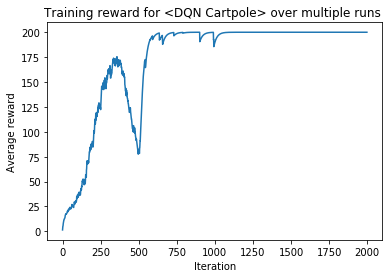

In [29]:
plt.plot(avg_rewards)
plt.title('Training reward for <DQN Cartpole> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

# DQN vs Reinforce

## CartPole (discrete action space)

In [ ]:
plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
plt.plot(step_list_ddpg, out) # or plt.plot(step_list_DQN, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) #or plt.legend(['DQN', 'REINFORCE'])
plt.plot(step_list_reinforce, avg_rewards)

plt.show()

# DDPG vs Reinforce

## Inverted Pendulum-v1

In [ ]:
plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
plt.plot(step_list_ddpg, out) # or plt.plot(step_list_DQN, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) #or plt.legend(['DQN', 'REINFORCE'])
plt.plot(step_list_reinforce, avg_rewards)

plt.show()

##  HalfCheetah-v1

In [ ]:
plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
plt.plot(step_list_ddpg, out) # or plt.plot(step_list_DQN, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) #or plt.legend(['DQN', 'REINFORCE'])
plt.plot(step_list_reinforce, avg_rewards)

plt.show()

In [ ]:
# running_rewards_ddpg1=np.load('ddpg_invpendulum_reward.npy')
# step_list_ddpg1=np.load('ddpg_invpendulum_step.npy')